In [1]:
from experiments.plots.util import *
from experiments.evaluation_flow.shared import *
import matplotlib

In [2]:
ROOT_LOG_DIR = '/Users/nils/downloads'
NORMAL_DIR = os.path.join(ROOT_LOG_DIR, 'normal')
D_5_DIR = os.path.join(ROOT_LOG_DIR, 'dist-5')
D_10_DIR = os.path.join(ROOT_LOG_DIR, 'dist-10')
D_20_DIR = os.path.join(ROOT_LOG_DIR, 'dist-20')


VERSION = 'version'
FINE_TUNED = 'fine-tuned'
OUTDOOR = 'outdoor'
FOOD = 'food'

TIME_OUTPUT_DIR = '/Users/nils/uni/mmlib-paper/master-thesis/experiments/plots/dist-exp/plots/time-compare'

In [3]:
def get_times(logs_dir, num_nodes):
    # %%
    # get all file sin the directory
    all_files = all_files_in_dir(logs_dir)
    node_server_files = [f for f in all_files if 'server' in f or 'node' in f]
    # for all files extract the metadata (e.g. what model and dataset is used)
    U_IDS = 'u_ids'
    files_and_meta = [(extract_file_meta(f), f) for f in node_server_files]
    # add a mapping: use_case -> model id
    files_and_meta = [({**f[0], **{U_IDS: use_case_ids(f[1])}}, f[1]) for f in files_and_meta]
    # add the parsed events
    files_and_meta = [({**f[0], **{EVENTS: parse_events(f[1])}}, f[1]) for f in files_and_meta]
    # %%
    valid_joined = join_server_and_node_meta(files_and_meta)
    # %%
    times = extract_times(valid_joined, num_nodes=num_nodes, high_level_only=True)

    return times

In [4]:
normal_times = get_times(NORMAL_DIR, 1)
d5_times = get_times(D_5_DIR, 5)
d10_times = get_times(D_10_DIR, 10)
d20_times = get_times(D_20_DIR, 20)


In [5]:
def every_nth_label(labels, n):
    for i in range(len(labels)):
        if not (i % n == 0):
            labels[i] = ''

    return labels


def to_s(values):
    return np.array(list(values)) * 10**-9

def plot_compare_times(baseline, param_update, provenance, save_path=None, ignore_use_cases=[], y_min_max=None, label_filter = None, enl=1):
    print('B: {}'.format(baseline))
    print('P_U: {}'.format(param_update))
    print('M_Prov: {}'.format(provenance))
    if ignore_use_cases:
        for u in ignore_use_cases:
            if u in baseline:
                del baseline[u]
            if u in param_update:
                del param_update[u]
            if u in provenance:
                del provenance[u]

    matplotlib.rcParams.update({'font.size': 24})
    x_labels = [k.replace('_', '-') for k in baseline.keys()]
    if label_filter:
        x_labels = [l.replace(label_filter, '') if label_filter in l or 'U-1' in l else '' for l in x_labels]
        every_nth_label(x_labels, enl)
    ind = np.arange(len(x_labels))  # the x locations for the groups
    width = 0.3  # the width of the bars
    fig = plt.figure()
    fig.set_size_inches(12, 6)
    ax = fig.add_subplot(111)
    rects3 = ax.bar(ind + 2 * width, to_s(provenance.values()), width, color=A_BLUE)
    rects2 = ax.bar(ind + width, to_s(param_update.values()), width, color=A_YELLOW)
    rects1 = ax.bar(ind, to_s(baseline.values()), width, color=A_RED)
    ax.set_ylabel('Time in seconds')
    ax.set_xticks(ind + width)
    ax.set_xticklabels(x_labels)
    # ax.legend((rects1[0], rects2[0], rects3[0]), ('B', 'U_p', 'M_prov'),
    #           bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)
    ax.set_xlabel('Use case')

    plt.xticks(rotation=90)

    if y_min_max:
        axes = plt.gca()
        axes.set_ylim(y_min_max)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight')
        fig.savefig(save_path + '.pdf', bbox_inches='tight')

    plt.show()

In [6]:
def plot_tts_compare(times, num_nodes, y_min_max=[0, 0.5], label_filter=None, enl=1, snapshot_type=VERSION):
    metas = filter_meta(times, model=MOBILENET, approach=BASELINE, snapshot_type=VERSION, snapshot_dist='outdoor')
    baseline_save_times = aggregate_fields(metas, aggregate='median', field_key=HIGH_LEVEL_SAVE_TIMES)[HIGH_LEVEL_SAVE_TIMES]

    metas = filter_meta(times, model=MOBILENET, approach=PARAM_UPDATE_IMPROVED, snapshot_type=snapshot_type, snapshot_dist='outdoor')
    improved_save_param_update_times = aggregate_fields(metas, aggregate='median', field_key=HIGH_LEVEL_SAVE_TIMES)[HIGH_LEVEL_SAVE_TIMES]

    metas = filter_meta(times, model=MOBILENET, approach='provenance', snapshot_type=VERSION, snapshot_dist='outdoor')
    prov_save_times = aggregate_fields(metas, aggregate='median', field_key=HIGH_LEVEL_SAVE_TIMES)[HIGH_LEVEL_SAVE_TIMES]

    save_path = os.path.join(TIME_OUTPUT_DIR, f'mobilenet-{snapshot_type}-tts-num-nodes-{num_nodes}')

    plot_compare_times(baseline_save_times, improved_save_param_update_times, prov_save_times, ignore_use_cases=[U_2],
                              save_path=save_path, y_min_max=y_min_max, label_filter=label_filter, enl=enl)


B: {'U_1': 100332354.0, 'U_2': 121477627.0, 'N0-U_3_1_1': 99619867.0, 'N0-U_3_1_2': 87850897.0, 'N0-U_3_1_3': 89735846.0, 'N0-U_3_1_4': 81316556.0, 'N0-U_3_2_1': 99830004.0, 'N0-U_3_2_2': 96061819.0, 'N0-U_3_2_3': 82713036.0, 'N0-U_3_2_4': 93982929.0}
P_U: {'U_1': 96000880.0, 'U_2': 119925831.0, 'N0-U_3_1_1': 99895880.0, 'N0-U_3_1_2': 86581545.0, 'N0-U_3_1_3': 81888476.0, 'N0-U_3_1_4': 81345818.0, 'N0-U_3_2_1': 95394475.0, 'N0-U_3_2_2': 90985568.0, 'N0-U_3_2_3': 79472490.0, 'N0-U_3_2_4': 83655604.0}
M_Prov: {'U_1': 100677990.0, 'U_2': 955119453.0, 'N0-U_3_1_1': 425540490.0, 'N0-U_3_1_2': 413072783.0, 'N0-U_3_1_3': 406923618.0, 'N0-U_3_1_4': 404681513.0, 'N0-U_3_2_1': 413135573.0, 'N0-U_3_2_2': 432429516.0, 'N0-U_3_2_3': 407709665.0, 'N0-U_3_2_4': 393941081.0}


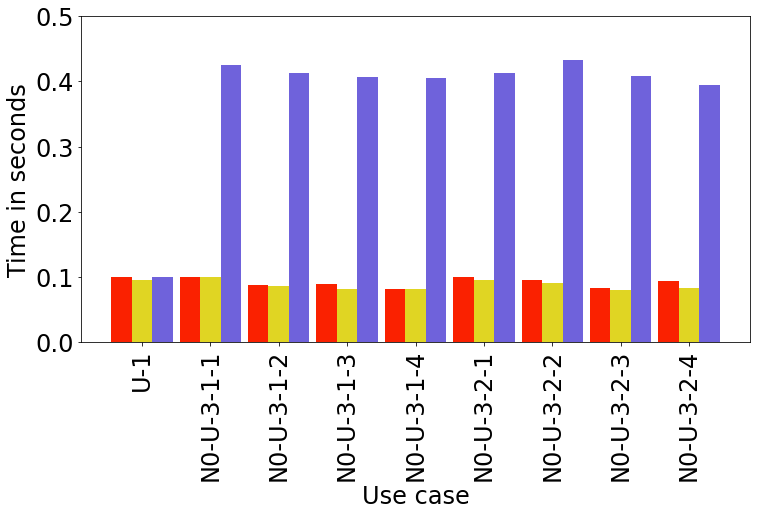

In [7]:
plot_tts_compare(normal_times, 1)

B: {'U_1': 100332354.0, 'U_2': 121477627.0, 'N0-U_3_1_1': 99619867.0, 'N0-U_3_1_2': 87850897.0, 'N0-U_3_1_3': 89735846.0, 'N0-U_3_1_4': 81316556.0, 'N0-U_3_2_1': 99830004.0, 'N0-U_3_2_2': 96061819.0, 'N0-U_3_2_3': 82713036.0, 'N0-U_3_2_4': 93982929.0}
P_U: {'U_1': 99723789.0, 'U_2': 91761055.0, 'N0-U_3_1_1': 76108770.0, 'N0-U_3_1_2': 65832378.0, 'N0-U_3_1_3': 62746082.0, 'N0-U_3_1_4': 60619090.0, 'N0-U_3_2_1': 79202520.0, 'N0-U_3_2_2': 63134426.0, 'N0-U_3_2_3': 60025869.0, 'N0-U_3_2_4': 69160439.0}
M_Prov: {'U_1': 100677990.0, 'U_2': 955119453.0, 'N0-U_3_1_1': 425540490.0, 'N0-U_3_1_2': 413072783.0, 'N0-U_3_1_3': 406923618.0, 'N0-U_3_1_4': 404681513.0, 'N0-U_3_2_1': 413135573.0, 'N0-U_3_2_2': 432429516.0, 'N0-U_3_2_3': 407709665.0, 'N0-U_3_2_4': 393941081.0}


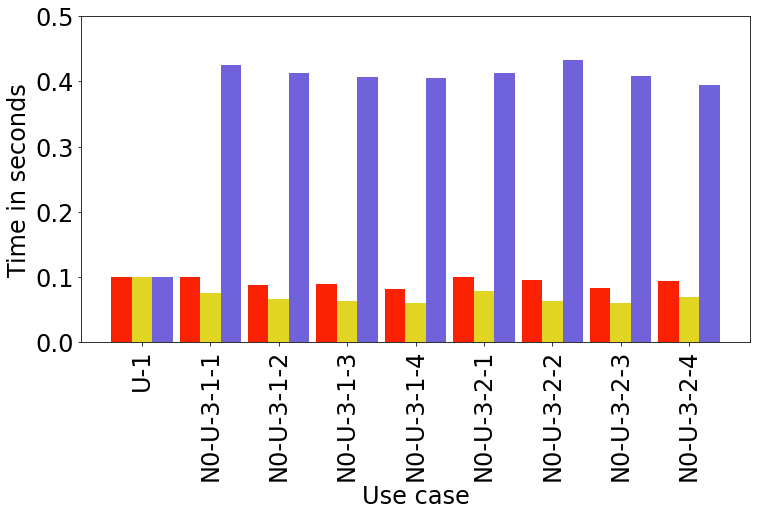

In [8]:
plot_tts_compare(normal_times, 1, snapshot_type=FINE_TUNED)

B: {'U_1': 100915237.0, 'U_2': 96892670.0, 'N0-U_3_1_1': 107772059.0, 'N1-U_3_1_1': 90008049.0, 'N2-U_3_1_1': 70478114.0, 'N3-U_3_1_1': 84584802.0, 'N4-U_3_1_1': 84437765.0, 'N0-U_3_1_2': 76392094.0, 'N1-U_3_1_2': 77288094.0, 'N2-U_3_1_2': 78203585.0, 'N3-U_3_1_2': 79223763.0, 'N4-U_3_1_2': 73976314.0, 'N0-U_3_1_3': 73149880.0, 'N1-U_3_1_3': 72860570.0, 'N2-U_3_1_3': 80291629.0, 'N3-U_3_1_3': 78301855.0, 'N4-U_3_1_3': 82209814.0, 'N0-U_3_1_4': 77752717.0, 'N1-U_3_1_4': 74852808.0, 'N2-U_3_1_4': 77412207.0, 'N3-U_3_1_4': 80340925.0, 'N4-U_3_1_4': 76757114.0, 'N0-U_3_1_5': 79783119.0, 'N1-U_3_1_5': 77250792.0, 'N2-U_3_1_5': 77273757.0, 'N3-U_3_1_5': 75071057.0, 'N4-U_3_1_5': 75254441.0, 'N0-U_3_1_6': 76949126.0, 'N1-U_3_1_6': 74529650.0, 'N2-U_3_1_6': 80927930.0, 'N3-U_3_1_6': 78743340.0, 'N4-U_3_1_6': 76178932.0, 'N0-U_3_1_7': 74785434.0, 'N1-U_3_1_7': 71730755.0, 'N2-U_3_1_7': 77578258.0, 'N3-U_3_1_7': 74766627.0, 'N4-U_3_1_7': 71316899.0, 'N0-U_3_1_8': 71669080.0, 'N1-U_3_1_8': 925331

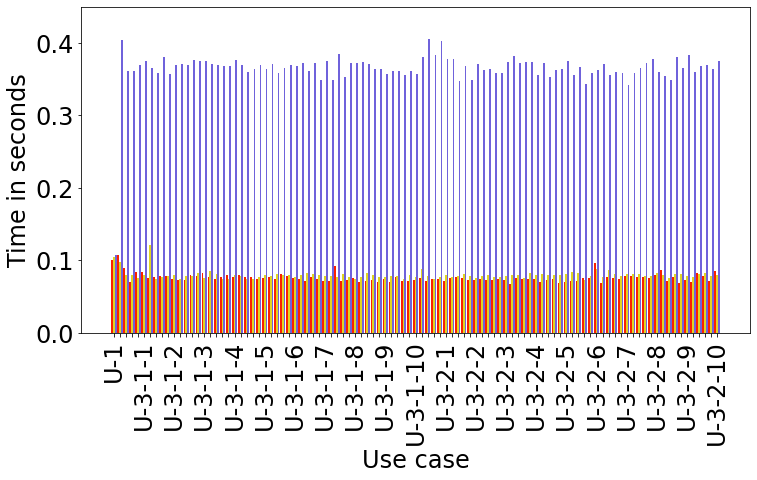

In [9]:
plot_tts_compare(d5_times, 5, [0,0.45], label_filter='N4-')

B: {'U_1': 107571740.0, 'U_2': 120855015.0, 'N0-U_3_1_1': 103711977.0, 'N1-U_3_1_1': 84720626.0, 'N2-U_3_1_1': 86906012.5, 'N3-U_3_1_1': 87515045.5, 'N4-U_3_1_1': 81689010.0, 'N5-U_3_1_1': 84748088.5, 'N6-U_3_1_1': 82669864.5, 'N7-U_3_1_1': 77994636.5, 'N8-U_3_1_1': 86408355.5, 'N9-U_3_1_1': 87825817.5, 'N0-U_3_1_2': 78861132.5, 'N1-U_3_1_2': 82737405.0, 'N2-U_3_1_2': 86253375.0, 'N3-U_3_1_2': 84739299.0, 'N4-U_3_1_2': 84236556.0, 'N5-U_3_1_2': 90449225.0, 'N6-U_3_1_2': 85594843.5, 'N7-U_3_1_2': 81787309.0, 'N8-U_3_1_2': 90522529.5, 'N9-U_3_1_2': 90945103.5, 'N0-U_3_1_3': 83965533.0, 'N1-U_3_1_3': 83904435.5, 'N2-U_3_1_3': 85485917.0, 'N3-U_3_1_3': 85399588.0, 'N4-U_3_1_3': 78740312.0, 'N5-U_3_1_3': 79581874.0, 'N6-U_3_1_3': 92392566.0, 'N7-U_3_1_3': 84827186.5, 'N8-U_3_1_3': 83123992.0, 'N9-U_3_1_3': 84410680.0, 'N0-U_3_1_4': 85333477.0, 'N1-U_3_1_4': 78058542.0, 'N2-U_3_1_4': 85743826.5, 'N3-U_3_1_4': 82574887.0, 'N4-U_3_1_4': 84000877.5, 'N5-U_3_1_4': 83231357.0, 'N6-U_3_1_4': 11295

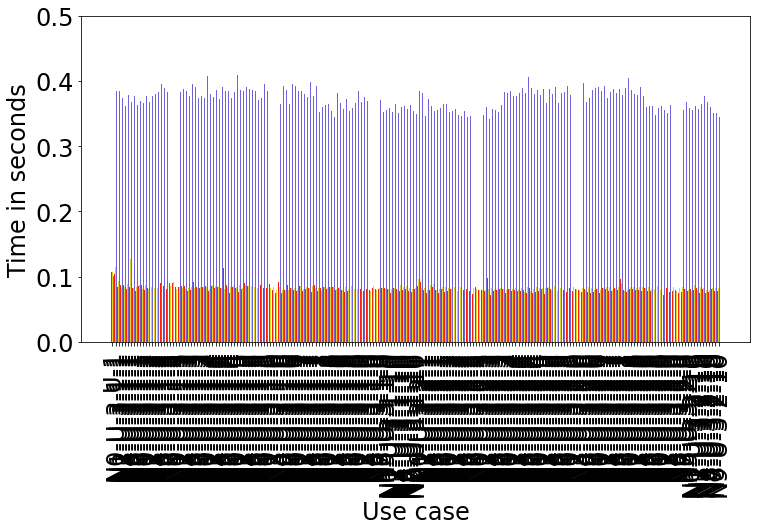

In [10]:
plot_tts_compare(d10_times, 10)

B: {'U_1': 104622383.0, 'U_2': 106140895.5, 'N0-U_3_1_1': 96989190.5, 'N1-U_3_1_1': 78851854.5, 'N2-U_3_1_1': 80471362.5, 'N3-U_3_1_1': 83335360.5, 'N4-U_3_1_1': 82190278.0, 'N5-U_3_1_1': 77268178.5, 'N6-U_3_1_1': 86602768.5, 'N7-U_3_1_1': 75945407.0, 'N8-U_3_1_1': 77249679.5, 'N9-U_3_1_1': 83629637.0, 'N10-U_3_1_1': 82174821.5, 'N11-U_3_1_1': 84502906.5, 'N12-U_3_1_1': 86646839.0, 'N13-U_3_1_1': 82014235.0, 'N14-U_3_1_1': 79355132.5, 'N15-U_3_1_1': 81559312.5, 'N16-U_3_1_1': 79929194.0, 'N17-U_3_1_1': 79588410.0, 'N18-U_3_1_1': 80011037.5, 'N19-U_3_1_1': 73682503.5, 'N0-U_3_1_2': 82472031.5, 'N1-U_3_1_2': 76064705.0, 'N2-U_3_1_2': 82282228.5, 'N3-U_3_1_2': 80704210.0, 'N4-U_3_1_2': 85953261.0, 'N5-U_3_1_2': 76493755.5, 'N6-U_3_1_2': 79584106.0, 'N7-U_3_1_2': 82471860.5, 'N8-U_3_1_2': 81111795.0, 'N9-U_3_1_2': 77893604.5, 'N10-U_3_1_2': 81868101.0, 'N11-U_3_1_2': 80489378.0, 'N12-U_3_1_2': 80433413.5, 'N13-U_3_1_2': 78295590.5, 'N14-U_3_1_2': 82932690.0, 'N15-U_3_1_2': 83841997.5, 'N16

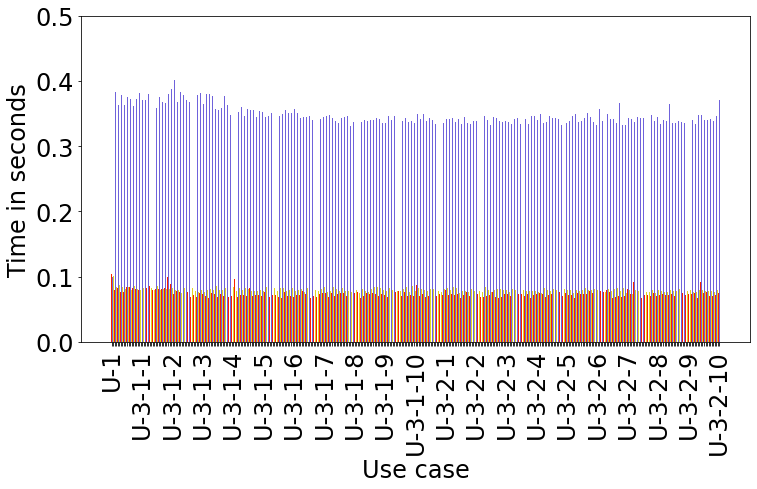

In [11]:
plot_tts_compare(d20_times, 20, label_filter='N19-', enl=20)

In [12]:
def plot_ttr_compare(times, num_nodes, y_min_max, label_filter=None, enl=1, snapshot_type=VERSION):
    metas = filter_meta(times, model=MOBILENET, approach=BASELINE, snapshot_type=VERSION, snapshot_dist='outdoor')
    baseline_save_times = aggregate_fields(metas, aggregate='median', field_key=HIGH_LEVEL_RECOVER_TIMES)[HIGH_LEVEL_RECOVER_TIMES]

    metas = filter_meta(times, model=MOBILENET, approach=PARAM_UPDATE_IMPROVED, snapshot_type=snapshot_type, snapshot_dist='outdoor')
    improved_save_param_update_times = aggregate_fields(metas, aggregate='median', field_key=HIGH_LEVEL_RECOVER_TIMES)[HIGH_LEVEL_RECOVER_TIMES]

    metas = filter_meta(times, model=MOBILENET, approach='provenance', snapshot_type=VERSION, snapshot_dist='outdoor')
    prov_save_times = aggregate_fields(metas, aggregate='median', field_key=HIGH_LEVEL_RECOVER_TIMES)[HIGH_LEVEL_RECOVER_TIMES]

    save_path = os.path.join(TIME_OUTPUT_DIR, f'mobilenet-{snapshot_type}-ttr-num-nodes-{num_nodes}')

    plot_compare_times(baseline_save_times, improved_save_param_update_times, prov_save_times, ignore_use_cases=[U_2],
                              save_path=save_path, y_min_max=y_min_max, label_filter=label_filter, enl=enl)

B: {'U_1': 1401021163.0, 'N0_U_3_1_1': 1423608849.0, 'N0_U_3_1_2': 1438621455.0, 'N0_U_3_1_3': 1426242635.0, 'N0_U_3_1_4': 1420494104.0, 'U_2': 1389048984.0, 'N0_U_3_2_1': 1462589717.0, 'N0_U_3_2_2': 1431396504.0, 'N0_U_3_2_3': 1407643398.0, 'N0_U_3_2_4': 1431113461.0}
P_U: {'U_1': 1418075059.0, 'N0_U_3_1_1': 1509328685.0, 'N0_U_3_1_2': 1596783126.0, 'N0_U_3_1_3': 1680649297.0, 'N0_U_3_1_4': 1724665507.0, 'U_2': 1467022835.0, 'N0_U_3_2_1': 1586009047.0, 'N0_U_3_2_2': 1666217631.0, 'N0_U_3_2_3': 1703403117.0, 'N0_U_3_2_4': 1794271195.0}
M_Prov: {'U_1': 174897722.0, 'N0_U_3_1_1': 1559936751.0, 'N0_U_3_1_2': 3511290855.0, 'N0_U_3_1_3': 4389900511.0, 'N0_U_3_1_4': 5432038225.0, 'U_2': 2534362647.0, 'N0_U_3_2_1': 4168158498.0, 'N0_U_3_2_2': 5413396170.0, 'N0_U_3_2_3': 6899138064.0, 'N0_U_3_2_4': 7905103816.0}


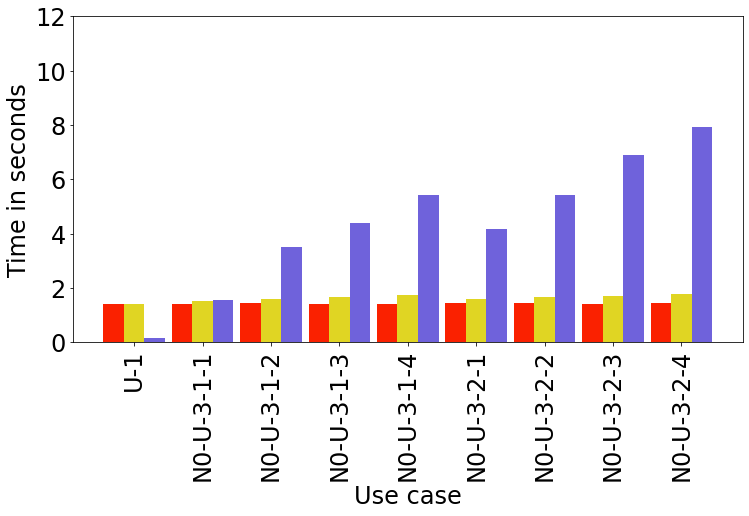

In [13]:
plot_ttr_compare(normal_times, 1, [0,12])

B: {'U_1': 1401021163.0, 'N0_U_3_1_1': 1423608849.0, 'N0_U_3_1_2': 1438621455.0, 'N0_U_3_1_3': 1426242635.0, 'N0_U_3_1_4': 1420494104.0, 'U_2': 1389048984.0, 'N0_U_3_2_1': 1462589717.0, 'N0_U_3_2_2': 1431396504.0, 'N0_U_3_2_3': 1407643398.0, 'N0_U_3_2_4': 1431113461.0}
P_U: {'U_1': 1432369903.0, 'N0_U_3_1_1': 1484016974.0, 'N0_U_3_1_2': 1543408507.0, 'N0_U_3_1_3': 1620648642.0, 'N0_U_3_1_4': 1639113135.0, 'U_2': 1446777866.0, 'N0_U_3_2_1': 1527897787.0, 'N0_U_3_2_2': 1592045496.0, 'N0_U_3_2_3': 1671373546.0, 'N0_U_3_2_4': 1702174818.0}
M_Prov: {'U_1': 174897722.0, 'N0_U_3_1_1': 1559936751.0, 'N0_U_3_1_2': 3511290855.0, 'N0_U_3_1_3': 4389900511.0, 'N0_U_3_1_4': 5432038225.0, 'U_2': 2534362647.0, 'N0_U_3_2_1': 4168158498.0, 'N0_U_3_2_2': 5413396170.0, 'N0_U_3_2_3': 6899138064.0, 'N0_U_3_2_4': 7905103816.0}


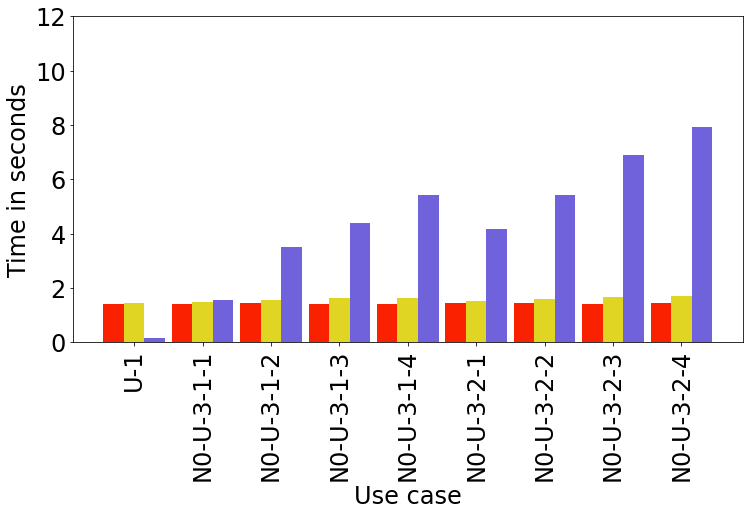

In [14]:
plot_ttr_compare(normal_times, 1, [0,12], snapshot_type=FINE_TUNED)

B: {'U_1': 1379556800.0, 'N0_U_3_1_1': 1343898752.0, 'N1_U_3_1_1': 1368057184.0, 'N2_U_3_1_1': 1357418361.0, 'N3_U_3_1_1': 1420851629.0, 'N4_U_3_1_1': 1417581331.0, 'N0_U_3_1_2': 1457973394.0, 'N1_U_3_1_2': 1430043031.0, 'N2_U_3_1_2': 1382188772.0, 'N3_U_3_1_2': 1439006132.0, 'N4_U_3_1_2': 1404819311.0, 'N0_U_3_1_3': 1418634515.0, 'N1_U_3_1_3': 1413160040.0, 'N2_U_3_1_3': 1396054368.0, 'N3_U_3_1_3': 1378414490.0, 'N4_U_3_1_3': 1428796674.0, 'N0_U_3_1_4': 1422501902.0, 'N1_U_3_1_4': 1420733413.0, 'N2_U_3_1_4': 1371498368.0, 'N3_U_3_1_4': 1430791537.0, 'N4_U_3_1_4': 1427626294.0, 'N0_U_3_1_5': 1449657187.0, 'N1_U_3_1_5': 1427806978.0, 'N2_U_3_1_5': 1409518755.0, 'N3_U_3_1_5': 1398404535.0, 'N4_U_3_1_5': 1412384285.0, 'N0_U_3_1_6': 1411815899.0, 'N1_U_3_1_6': 1416837449.0, 'N2_U_3_1_6': 1425913153.0, 'N3_U_3_1_6': 1427790410.0, 'N4_U_3_1_6': 1405041000.0, 'N0_U_3_1_7': 1422876112.0, 'N1_U_3_1_7': 1403480995.0, 'N2_U_3_1_7': 1407398184.0, 'N3_U_3_1_7': 1409885310.0, 'N4_U_3_1_7': 143334590

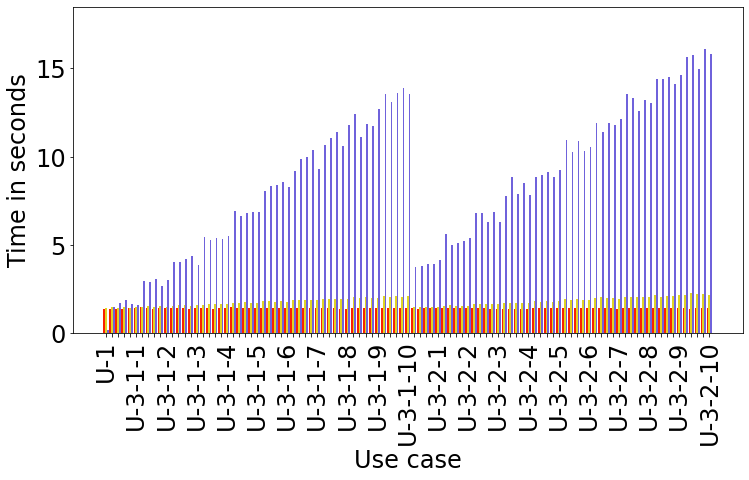

In [15]:
plot_ttr_compare(d5_times, 5, [0,18.5], label_filter='N4-')

B: {'U_1': 1420870577.0, 'N0_U_3_1_1': 1423174043.0, 'N1_U_3_1_1': 1429906567.5, 'N2_U_3_1_1': 1438438906.0, 'N3_U_3_1_1': 1437703692.5, 'N4_U_3_1_1': 1440018642.5, 'N5_U_3_1_1': 1472608944.5, 'N6_U_3_1_1': 1428279028.5, 'N7_U_3_1_1': 1417534096.5, 'N8_U_3_1_1': 1440584504.5, 'N9_U_3_1_1': 1422958947.0, 'N0_U_3_1_2': 1427691999.5, 'N1_U_3_1_2': 1427143465.5, 'N2_U_3_1_2': 1422945158.0, 'N3_U_3_1_2': 1432329073.5, 'N4_U_3_1_2': 1425079402.5, 'N5_U_3_1_2': 1426323917.5, 'N6_U_3_1_2': 1418562610.0, 'N7_U_3_1_2': 1444313780.0, 'N8_U_3_1_2': 1421144359.0, 'N9_U_3_1_2': 1445529210.5, 'N0_U_3_1_3': 1454245626.0, 'N1_U_3_1_3': 1419467395.0, 'N2_U_3_1_3': 1425086502.5, 'N3_U_3_1_3': 1441577365.0, 'N4_U_3_1_3': 1429208900.5, 'N5_U_3_1_3': 1413348064.0, 'N6_U_3_1_3': 1414442753.5, 'N7_U_3_1_3': 1423936278.5, 'N8_U_3_1_3': 1419441444.5, 'N9_U_3_1_3': 1426205036.5, 'N0_U_3_1_4': 1425963380.0, 'N1_U_3_1_4': 1420856763.5, 'N2_U_3_1_4': 1420808679.5, 'N3_U_3_1_4': 1418843205.0, 'N4_U_3_1_4': 145606322

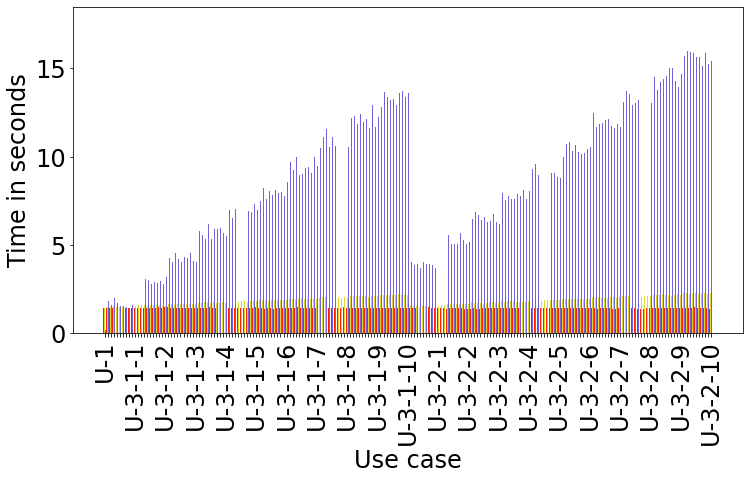

In [16]:
plot_ttr_compare(d10_times, 10, [0,18.5], label_filter='N9-')

B: {'U_1': 1393224916.5, 'N0_U_3_1_1': 1405564752.5, 'N1_U_3_1_1': 1420874277.5, 'N2_U_3_1_1': 1398085176.5, 'N3_U_3_1_1': 1448810846.0, 'N4_U_3_1_1': 1412777881.0, 'N5_U_3_1_1': 1450569891.5, 'N6_U_3_1_1': 1356476810.5, 'N7_U_3_1_1': 1367513987.5, 'N8_U_3_1_1': 1426386255.0, 'N9_U_3_1_1': 1410761712.0, 'N10_U_3_1_1': 1411310389.5, 'N11_U_3_1_1': 1394815233.5, 'N12_U_3_1_1': 1391558950.5, 'N13_U_3_1_1': 1411698676.0, 'N14_U_3_1_1': 1402309815.5, 'N15_U_3_1_1': 1425307870.5, 'N16_U_3_1_1': 1403135287.5, 'N17_U_3_1_1': 1429291594.0, 'N18_U_3_1_1': 1417315856.5, 'N19_U_3_1_1': 1401672652.0, 'N0_U_3_1_2': 1406184326.5, 'N1_U_3_1_2': 1408027825.5, 'N2_U_3_1_2': 1384382020.5, 'N3_U_3_1_2': 1377520426.5, 'N4_U_3_1_2': 1379673750.5, 'N5_U_3_1_2': 1404336991.5, 'N6_U_3_1_2': 1403306334.0, 'N7_U_3_1_2': 1394946879.0, 'N8_U_3_1_2': 1390936342.0, 'N9_U_3_1_2': 1404372606.0, 'N10_U_3_1_2': 1388764545.0, 'N11_U_3_1_2': 1356521789.5, 'N12_U_3_1_2': 1373529891.0, 'N13_U_3_1_2': 1387210693.0, 'N14_U_3_

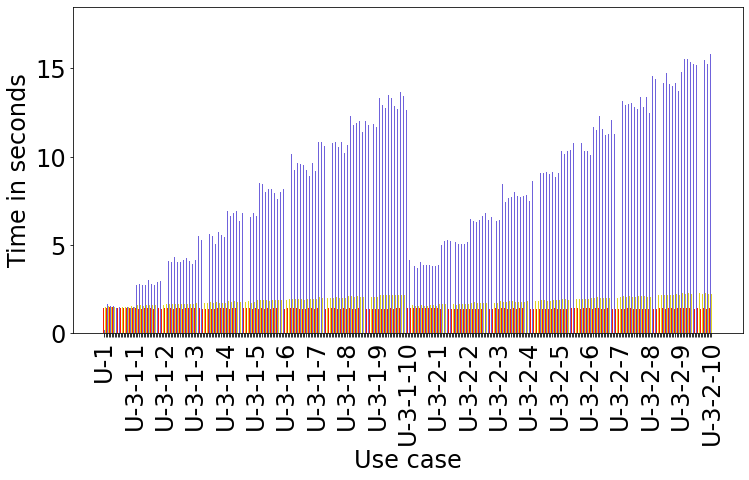

In [17]:
plot_ttr_compare(d20_times, 20, [0,18.5], label_filter='N19-', enl=20)